# Определение популярности геолокации для размещения банкомата (на примере Москвы)

Это ачалльная версия проекта.  
На текущем этапе реализованы:

- сбор данных из OpenStreetMap (банкоматы и объекты инфраструктуры);
- первичная очистка и сокращение признаков;
- сохранение слоёв данных в формате GeoJSON.

**Цель проекта** — подготовить данные для анализа факторов популярности расположения банкоматов и дальнейшего построения модели (ML).


## Использование библиотеки OSMnx

Для получения геоданных мы используем библиотеку **OSMnx**.  
Она работает поверх открытой картографической базы **OpenStreetMap (OSM)** и упрощает доступ к данным: зданиям, дорогам, точкам интереса (POI).  

- OpenStreetMap хранит объекты в виде **тегов** (`amenity=atm`, `shop=supermarket`, `highway=bus_stop` и т.д.).  
- OSMnx строит запросы к серверу OSM (Overpass API) и возвращает данные в формате **GeoDataFrame** (таблица + геометрия).  
- Эти данные можно сразу анализировать или сохранять в файлы (`.geojson`, `.shp`, `.csv`).  

В проекте:  
1. Определяем территорию (`place="Moscow, Russia"`).  
2. Указываем нужные теги (например, `amenity=atm` для банкоматов).  
3. Получаем таблицу с координатами и атрибутами объектов.  
4. Сохраняем её в `data/raw/`, чтобы работать дальше без повторных запросов.  

Таким образом, OSMnx позволяет автоматизировать сбор пространственных данных и использовать их для анализа и построения признаков в ML-модели.


### Сбор данных о банкоматах Москвы

На этом шаге выгружаем из OpenStreetMap все объекты с тегом `amenity=atm`.  
Эти точки будут использоваться как целевые объекты анализа — именно для них будем искать факторы популярности.  

Полученные данные:  
- содержат координаты (`geometry`);  
- включают дополнительные атрибуты (например, оператор сети, наличие функции приёма наличных);  
- сохраняются в папку `data/raw/` в формате GeoJSON, чтобы далее использовать их без повторных запросов к API.  

Таким образом, формируем исходный слой данных для последующей очистки и построения признаков.


In [134]:
# pip install osmnx geopandas

import osmnx as ox
import geopandas as gpd

In [138]:
# проверка установки
print("OSMnx:", ox.__version__)
print("GeoPandas:", gpd.__version__)


OSMnx: 2.0.6
GeoPandas: 1.1.1


Выбираем данные

In [141]:
# Определяем регион
place = "Moscow, Russia"

# Указываем нужный тег (банкоматы)
tags = {"amenity": "atm"}

# Загружаем данные из OpenStreetMap
gdf_atm = ox.features_from_place(place, tags)

# Проверяем размерность и первые строки
print("Размер набора данных:", gdf_atm.shape)
gdf_atm.head()


Размер набора данных: (2059, 91)


geometry amenity  \
element id                                         
node    408385048   POINT (37.702 55.76)     atm   
        432502063  POINT (37.602 55.779)     atm   
        444776906  POINT (37.524 55.804)     atm   
        444776911  POINT (37.432 55.857)     atm   
        444776938  POINT (37.504 55.743)     atm   

                                                       contact:phone  \
element id                                                             
node    408385048                                     +7 800 5555550   
        432502063                                     +7 800 1002424   
        444776906                                                NaN   
        444776911  +7 495 7774888;+7 495 7974242;+7 800 1004888;+...   
        444776938                                                NaN   

                            contact:website                         operator  \
element id                                                                     
node    408385048  https://www.sberbank.ru/                     ПАО Сбербанк   
        432502063       https://www.vtb.ru/                   Банк ВТБ (ПАО)   
        444776906       https://alfabank.ru                       Альфа-Банк   
        444776911           https://mkb.ru/  ПАО "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК"   
        444776938       https://alfabank.ru                  АО "Альфа-Банк"   

                        brand covered drive_through      opening_hours  \
element id                                                               
node    408385048    Сбербанк     NaN           NaN               24/7   
        432502063         ВТБ     NaN           NaN                NaN   
        444776906  Альфа-Банк     NaN           NaN                NaN   
        444776911         NaN     NaN           NaN  Mo-Su 09:00-23:00   
        444776938  Альфа-Банк     NaN           NaN                NaN   

                  wheelchair  ... currency:XBT  bic currency:ETH  \
element id                    ...                                  
node    408385048        NaN  ...          NaN  NaN          NaN   
        432502063        NaN  ...          NaN  NaN          NaN   
        444776906        NaN  ...          NaN  NaN          NaN   
        444776911        NaN  ...          NaN  NaN          NaN   
        444776938        yes  ...          NaN  NaN          NaN   

                  currency:USDT image payment:cash payment:onchain  url  \
element id                                                                
node    408385048           NaN   NaN          NaN             NaN  NaN   
        432502063           NaN   NaN          NaN             NaN  NaN   
        444776906           NaN   NaN          NaN             NaN  NaN   
        444776911           NaN   NaN          NaN             NaN  NaN   
        444776938           NaN   NaN          NaN             NaN  NaN   

                  wikipedia survey:date  
element id                               
node    408385048       NaN         NaN  
        432502063       NaN         NaN  
        444776906       NaN         NaN  
        444776911       NaN         NaN  
        444776938       NaN         NaN  

[5 rows x 91 columns]

Сохраняем результат в папку `data/raw/` в формате GeoJSON.  



In [144]:
import os

# Гарантируем, что папка существует
os.makedirs("data/raw", exist_ok=True)

# Путь к файлу
output_path = "data/raw/atm_moscow.geojson"

# Сохраняем в GeoJSON
gdf_atm.to_file(output_path, driver="GeoJSON")
print(f"Файл сохранён: {os.path.abspath(output_path)}")
print(f"Размер файла: {os.path.getsize(output_path)/(1024*1024):.2f} МБ")


Файл сохранён: C:\Users\LENOVO\YandexDisk\Git_hub\final-project-atm-analysis\notebooks\data\raw\atm_moscow.geojson
Размер файла: 4.14 МБ


## Сбор точек интереса (POI)

Для анализа популярности геолокаций выгружаем объекты, которые могут влиять на трафик:
- магазины и супермаркеты (`shop=supermarket`, `shop=convenience`);
- кафе и рестораны (`amenity=cafe`, `amenity=restaurant`);
- аптеки (`amenity=pharmacy`);
- остановки общественного транспорта (`highway=bus_stop`).

Эти данные будут использоваться для построения признаков в модели.


In [171]:
# Определяем регион
place = "Moscow, Russia"

# Задаём несколько тегов для выборки POI
tags = {
    "shop": ["supermarket", "convenience"],
    "amenity": ["cafe", "restaurant", "pharmacy"],
    "highway": "bus_stop"
}

# Загружаем все объекты
gdf_poi = ox.features_from_place(place, tags)

print("Размер набора данных:", gdf_poi.shape)
gdf_poi.head()


Размер набора данных: (32619, 398)


geometry bench  bus   highway  \
element id                                                      
node    1000       POINT (37.208 55.995)   NaN  NaN       NaN   
        87761966   POINT (37.425 55.694)   NaN  NaN  bus_stop   
        112549000  POINT (37.527 55.652)   NaN  NaN       NaN   
        250559783  POINT (37.418 55.808)   yes  yes  bus_stop   
        252899807  POINT (37.665 55.732)   yes  yes  bus_stop   

                                   name public_transport shelter  bin  \
element id                                                              
node    1000                  Десяточка              NaN     NaN  NaN   
        87761966    Рябиновая улица, 51         platform     NaN  NaN   
        112549000              Креветка              NaN     NaN  NaN   
        250559783  Аллея «Дорога жизни»         platform     yes  yes   
        252899807  Метро «Пролетарская»         platform     yes  yes   

                          shop amenity  ... stars building:min_level  \
element id                              ...                            
node    1000       supermarket     NaN  ...   NaN                NaN   
        87761966           NaN     NaN  ...   NaN                NaN   
        112549000          NaN    cafe  ...   NaN                NaN   
        250559783          NaN     NaN  ...   NaN                NaN   
        252899807          NaN     NaN  ...   NaN                NaN   

                  drink:sparkling_wine drink:wine library weather_protection  \
element id                                                                     
node    1000                       NaN        NaN     NaN                NaN   
        87761966                   NaN        NaN     NaN                NaN   
        112549000                  NaN        NaN     NaN                NaN   
        250559783                  NaN        NaN     NaN                NaN   
        252899807                  NaN        NaN     NaN                NaN   

                  railway type mapillary landuse  
element id                                        
node    1000          NaN  NaN       NaN     NaN  
        87761966      NaN  NaN       NaN     NaN  
        112549000     NaN  NaN       NaN     NaN  
        250559783     NaN  NaN       NaN     NaN  
        252899807     NaN  NaN       NaN     NaN  

[5 rows x 398 columns]

Сырые данные сохраняем в папку `data/raw`.  
Этот набор используется как базовый источник для дальнейшей очистки и построения признаков.  
  
Дополнительно для передачи сохранён архив с полной выгрузкой.



In [174]:
# Сохраняем выгрузку
raw_path = "../data/raw/poi_moscow.geojson"
gdf_poi.to_file(raw_path, driver="GeoJSON")

print(f"Файл сохранён: {os.path.abspath(raw_path)}")
print(f"Размер файла: {os.path.getsize(raw_path)/(1024*1024):.2f} МБ")


---

# Подготовка выгрузок данных

## Первичная оценка данных ATM

Для понимания структуры выгрузки посмотрим:  
- размер таблицы (число строк и колонок);  
- список колонок;  
- долю заполненных значений по каждой колонке.  

Это позволит определить, какие атрибуты можно использовать для анализа.


In [202]:
# Размер таблицы
print("Размер набора данных:", gdf_atm.shape)

# # Список колонок
# print("\nКолонки в наборе данных:")
# print(gdf_atm.columns.tolist())

# Доля заполненных значений в процентах
missing = gdf_atm.isna().mean().round(2) * 100
print("\nДоля пропусков (%):")
print(missing.sort_values())


Размер набора данных: (2059, 91)

Доля пропусков (%):
geometry             0.0
amenity              0.0
operator             4.0
contact:website      7.0
brand               16.0
                   ...  
floor              100.0
location           100.0
language:de        100.0
source:date        100.0
survey:date        100.0
Length: 91, dtype: float64


## Очистка данных ATM

После первичной очистки в данных по точкам интереса остаётся много редко заполненных атрибутов.  
Чтобы сократить размер набора и оставить только информативные признаки, используем порог заполненности:  
- сохраняем только те колонки, где заполнено не менее 10% значений,  
- дополнительно оставляем ключевые признаки (`geometry`, `name`, `shop`, `amenity`, `highway`, `public_transport`).



В выгрузке по банкоматам также содержится большое количество редко заполненных атрибутов.  
Для оптимизации данных оставляем только информативные признаки:  
- сохраняем колонки с заполненностью не менее 10%;  
- дополнительно оставляем ключевые признаки (`geometry`, `name`, `amenity`, `operator`, `brand`).  


In [161]:
# Считаем долю пропусков
missing_atm = gdf_atm.isna().mean().round(2) * 100

# Порог заполненности (≥10% данных должно быть заполнено)
threshold = 0.1  
valid_cols_atm = missing_atm[missing_atm < (100 - threshold * 100)].index.tolist()

# Добавляем ключевые признаки вручную
keep_cols_atm = list(set(valid_cols_atm + ["geometry", "name", "amenity", "operator", "brand"]))

# Новый датафрейм
atm_clean = gdf_atm[keep_cols_atm].copy()

# Фильтруем только точки (банкоматы представлены как Point)
atm_clean = atm_clean[atm_clean.geometry.geom_type == "Point"]

# Проверяем результат
print("Размер отчищенных данных:", atm_clean.shape)

print("\nДоля пропусков (%):")
missing_clean_atm = atm_clean.isna().mean().round(2) * 100
print(missing_clean_atm.sort_values())


Размер отчищенных данных: (2059, 20)

Доля пропусков (%):
amenity                0.0
geometry               0.0
operator               4.0
contact:website        7.0
brand                 16.0
contact:phone         20.0
opening_hours         54.0
operator:wikidata     63.0
brand:wikidata        63.0
brand:en              67.0
brand:ru              76.0
operator:wikipedia    80.0
contact:email         81.0
brand:wikipedia       86.0
cash_in               87.0
level                 88.0
check_date            88.0
contact:vk            88.0
currency:RUB          88.0
name                  99.0
dtype: float64


Уберём слабо заполненные столбцы и оставим только информативные:
- базовые: `geometry`, `amenity`, `operator`, `brand`, `name`;
- дополнительные — c заполненностью не ниже выбранного порога (например, ≥30%).

Это уменьшит размер набора и упростит дальнейший анализ.


In [164]:
# Выбираем только нужные колонки
keep_cols = ["geometry", "amenity", "operator", "brand", "cash_in", "opening_hours"]
atm_clean = atm_clean[keep_cols].copy()

print("Размер после очистки:", atm_clean.shape)
atm_clean.head()


Размер после очистки: (2059, 6)


geometry amenity  \
element id                                         
node    408385048   POINT (37.702 55.76)     atm   
        432502063  POINT (37.602 55.779)     atm   
        444776906  POINT (37.524 55.804)     atm   
        444776911  POINT (37.432 55.857)     atm   
        444776938  POINT (37.504 55.743)     atm   

                                          operator       brand cash_in  \
element id                                                               
node    408385048                     ПАО Сбербанк    Сбербанк     NaN   
        432502063                   Банк ВТБ (ПАО)         ВТБ     NaN   
        444776906                       Альфа-Банк  Альфа-Банк     NaN   
        444776911  ПАО "МОСКОВСКИЙ КРЕДИТНЫЙ БАНК"         NaN     NaN   
        444776938                  АО "Альфа-Банк"  Альфа-Банк     NaN   

                       opening_hours  
element id                            
node    408385048               24/7  
        432502063                NaN  
        444776906                NaN  
        444776911  Mo-Su 09:00-23:00  
        444776938                NaN

Сохраняем отчищенные данные ATM

In [167]:
# Сохраняем результат в папку processed
os.makedirs("../data/processed", exist_ok=True)

# путь для сохранения
output_atm = "../data/processed/atm_clean.geojson"
# сохраняем очищенные данные
atm_clean.to_file(output_atm, driver="GeoJSON")

print(f"\nФайл сохранён: {os.path.abspath(output_atm)}")
print(f"Размер файла: {os.path.getsize(output_atm)/(1024*1024):.2f} МБ")



Файл сохранён: C:\Users\LENOVO\YandexDisk\Git_hub\final-project-atm-analysis\data\processed\atm_clean.geojson
Размер файла: 0.56 МБ


---

### Итоги очистки данных ATM

- В исходной выборке: **2 059 объектов**, **91 атрибут**.  
- После очистки оставлено: **6 ключевых колонок** (`geometry`, `amenity`, `operator`, `brand`, `cash_in`, `opening_hours`).  
- Удалены полностью пустые и редко заполненные поля.  
- Доля пропусков по базовым атрибутам минимальна (оператор заполнен ~96%, бренд ~84%).  
- Полученный слой компактный и пригоден для анализа и построения признаков.  


## Первичная оценка данных POI

Для понимания структуры набора посмотрим:  
- размер таблицы (число строк и колонок);  
- список колонок;  
- долю заполненных значений по каждой колонке.  
Это позволит определить, какие признаки действительно можно использовать.



In [147]:
# Размер таблицы
print("Размер набора данных:", gdf_poi.shape)

# # Список колонок
# print("\nКолонки в наборе данных:")
# print(gdf_poi.columns.tolist())

# Заполненность колонок в процентах
missing = gdf_poi.isna().mean().round(2) * 100
print("\nДоля пропусков (%):")
print(missing.sort_values())


Размер набора данных: (32619, 398)

Доля пропусков (%):
geometry               0.0
name                   9.0
opening_hours         61.0
amenity               62.0
public_transport      63.0
                     ...  
currency:RUB         100.0
diet:pescetarian     100.0
diet:lactose_free    100.0
craft_beer           100.0
landuse              100.0
Length: 398, dtype: float64


В исходном наборе более 300 колонок, боль.шинство из которых полностью пустые.  
Для оптимизации оставим только колонки с заполненностью выше 10%;  

In [150]:
# Минимальный порог заполненности
threshold = 0.1  

# Колонки с достаточной заполненностью
valid_cols = missing[missing < (100 - threshold * 100)].index.tolist()

# Обязательно добавляем ключевые признаки
keep_cols = list(set(valid_cols + ["geometry", "name", "shop", "amenity", "highway", "public_transport"]))

# Новый датафрейм
gdf_poi_clean = gdf_poi[keep_cols].copy()

print("Оставлено колонок:", len(gdf_poi_clean.columns))
gdf_poi_clean.head()



Оставлено колонок: 26


highway bench contact:website name:en  bin amenity  \
element id                                                               
node    1000            NaN   NaN             NaN     NaN  NaN     NaN   
        87761966   bus_stop   NaN             NaN     NaN  NaN     NaN   
        112549000       NaN   NaN             NaN     NaN  NaN    cafe   
        250559783  bus_stop   yes             NaN     NaN  yes     NaN   
        252899807  bus_stop   yes             NaN     NaN  yes     NaN   

                  public_transport contact:email contact:instagram contact:vk  \
element id                                                                      
node    1000                   NaN           NaN               NaN        NaN   
        87761966          platform           NaN               NaN        NaN   
        112549000              NaN           NaN               NaN        NaN   
        250559783         platform           NaN               NaN        NaN   
        252899807         platform           NaN               NaN        NaN   

                   ... healthcare contact:phone  bus contact:facebook  \
element id         ...                                                  
node    1000       ...        NaN           NaN  NaN              NaN   
        87761966   ...        NaN           NaN  NaN              NaN   
        112549000  ...        NaN           NaN  NaN              NaN   
        250559783  ...        NaN           NaN  yes              NaN   
        252899807  ...        NaN           NaN  yes              NaN   

                  brand:wikidata brand                  name shelter  \
element id                                                             
node    1000                 NaN   NaN             Десяточка     NaN   
        87761966             NaN   NaN   Рябиновая улица, 51     NaN   
        112549000            NaN   NaN              Креветка     NaN   
        250559783            NaN   NaN  Аллея «Дорога жизни»     yes   
        252899807            NaN   NaN  Метро «Пролетарская»     yes   

                  opening_hours  lit  
element id                            
node    1000        08:30-22:45  NaN  
        87761966            NaN  NaN  
        112549000           NaN  NaN  
        250559783           NaN  NaN  
        252899807           NaN  yes  

[5 rows x 26 columns]

In [152]:
# Смотрим размер отчищенных данных
print("Размер отчищенных данных:", gdf_poi_clean.shape)

# # Список колонок
# print("\nКолонки:")
# print(gdf_poi_clean.columns.tolist())

# Заполненность колонок в процентах
missing = gdf_poi_clean.isna().mean().round(2) * 100
print("\nДоля пропусков (%):")
print(missing.sort_values())

Размер отчищенных данных: (32619, 26)

Доля пропусков (%):
geometry              0.0
name                  9.0
opening_hours        61.0
amenity              62.0
highway              63.0
public_transport     63.0
bus                  66.0
name:uk              66.0
contact:website      71.0
shelter              72.0
shop                 75.0
bench                75.0
contact:phone        76.0
bin                  79.0
brand                80.0
brand:wikidata       84.0
lit                  84.0
contact:email        85.0
tactile_paving       85.0
cuisine              86.0
operator             87.0
contact:facebook     87.0
name:en              87.0
contact:instagram    88.0
contact:vk           88.0
healthcare           89.0
dtype: float64


In [197]:
# Удаляем полностью пустые столбцы
atm_clean = gdf_atm.dropna(axis=1, how="all").copy()

# Фильтруем только объекты типа Point
atm_clean = atm_clean[atm_clean.geometry.geom_type == "Point"]

# Проверим, какие колонки остались
print("Колонки после очистки:", atm_clean.columns.tolist())
print("Размер после очистки:", atm_clean.shape)

Колонки после очистки: ['geometry', 'amenity', 'contact:phone', 'contact:website', 'operator', 'brand', 'covered', 'drive_through', 'opening_hours', 'wheelchair', 'contact:email', 'contact:facebook', 'contact:instagram', 'currency:RUB', 'operator:wikidata', 'operator:wikipedia', 'level', 'check_date', 'cash_in', 'description', 'brand:en', 'brand:ru', 'brand:wikidata', 'brand:wikipedia', 'addr:full', 'indoor', 'name:en', 'name:ru', 'fixme', 'contact:ok', 'contact:telegram', 'contact:twitter', 'contact:vk', 'contact:youtube', 'ref', 'website', 'addr:housenumber', 'addr:street', 'comment', 'source', 'surveillance', 'note', 'contact:fax', 'addr:city', 'is_in:neighbourhood', 'addr:country', 'addr:postcode', 'addr:region', 'branch', 'source:date', 'email', 'phone', 'addr:floor', 'building:colour', 'brand:fa', 'brand:he', 'layer', 'currency:others', 'fee', 'currency:EUR', 'currency:USD', 'network', 'floor', 'location', 'access', 'language:de', 'language:en', 'language:others', 'language:ru', 

## Очистка данных POI

Для анализа нам нужны только ключевые признаки, которые характеризуют объекты:  
- `geometry` — координаты;  
- `name` — название;  
- `shop`, `amenity`, `highway`, `public_transport` — тип объекта;  
- `opening_hours`, `healthcare`, `operator` — потенциально полезные дополнительные поля.  

Все остальные колонки удаляем, чтобы уменьшить размер набора данных и убрать шум.


In [180]:
# Оставляем только нужные колонки
cols_to_keep = [
    "geometry", "name", "shop", "amenity", "highway",
    "public_transport", "opening_hours", "healthcare", "operator"
]

gdf_poi_clean = gdf_poi[cols_to_keep].copy()

print("Размер после очистки:", gdf_poi_clean.shape)
gdf_poi_clean.head()


Размер после очистки: (32619, 9)


geometry                  name         shop  \
element id                                                                    
node    1000       POINT (37.208 55.995)             Десяточка  supermarket   
        87761966   POINT (37.425 55.694)   Рябиновая улица, 51          NaN   
        112549000  POINT (37.527 55.652)              Креветка          NaN   
        250559783  POINT (37.418 55.808)  Аллея «Дорога жизни»          NaN   
        252899807  POINT (37.665 55.732)  Метро «Пролетарская»          NaN   

                  amenity   highway public_transport opening_hours healthcare  \
element id                                                                      
node    1000          NaN       NaN              NaN   08:30-22:45        NaN   
        87761966      NaN  bus_stop         platform           NaN        NaN   
        112549000    cafe       NaN              NaN           NaN        NaN   
        250559783     NaN  bus_stop         platform           NaN        NaN   
        252899807     NaN  bus_stop         platform           NaN        NaN   

                  operator  
element id                  
node    1000           NaN  
        87761966       NaN  
        112549000      NaN  
        250559783      NaN  
        252899807      NaN

### Сохраняем отчищенные данные POI

In [185]:
import os
print("Текущая рабочая директория:", os.getcwd())


Текущая рабочая директория: C:\Users\LENOVO\YandexDisk\Git_hub\final-project-atm-analysis\notebooks


In [183]:
# путь для сохранения
output_path = "../data/processed/poi_clean.geojson"

# сохраняем очищенные данные
gdf_poi_clean.to_file(output_path, driver="GeoJSON")

print(f"Файл сохранён: {os.path.abspath(output_path)}")
print(f"Размер файла: {os.path.getsize(output_path)/(1024*1024):.2f} МБ")


Файл сохранён: C:\Users\LENOVO\YandexDisk\Git_hub\final-project-atm-analysis\data\processed\poi_clean.geojson
Размер файла: 10.86 МБ


### Итоги очистки данных POI

- В исходной выборке: **32 619 объектов**, **398 атрибутов**, большинство из которых заполнено слабо.  
- После очистки оставлено: **26 информативных колонок** (в т.ч. `geometry`, `name`, `shop`, `amenity`, `highway`, `public_transport`).  
- Полностью пустые и слабо заполненные признаки удалены.  
- Доля пропусков по ключевым полям снизилась, набор стал компактнее и удобнее для анализа.  
- Полученный слой пригоден для дальнейшей генерации признаков (например, подсчёта количества POI вокруг каждой точки ATM).


# Подготовка геоданных: границы и проекция

Для корректного анализа необходимо:

1. Получить геометрические границы Москвы.  
   Это позволит в дальнейшем:
   - строить сетку точек-кандидатов только внутри города;
   - исключить объекты за пределами Москвы.  

2. Перевести все данные (банкоматы и POI) в метрическую проекцию (EPSG:3857).  
   Это важно для того, чтобы корректно измерять расстояния в метрах и строить буферы (например, круг радиусом 300 м).  


ATM: (2059, 8)
POI: (32619, 11)


<Axes: >

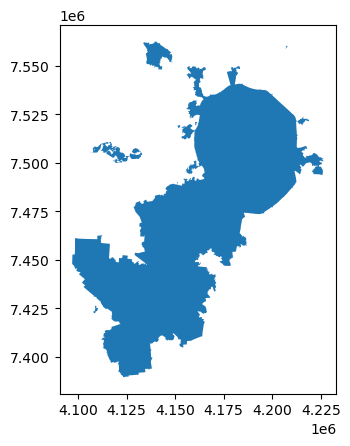

In [188]:
import geopandas as gpd
import osmnx as ox

# Получаем границы Москвы
city = ox.geocode_to_gdf("Moscow, Russia")[["geometry"]].to_crs(3857)

# Загружаем очищенные данные
atm = gpd.read_file("../data/processed/atm_clean.geojson").to_crs(3857)
poi = gpd.read_file("../data/processed/poi_clean.geojson").to_crs(3857)

# Проверим размер
print("ATM:", atm.shape)
print("POI:", poi.shape)


# Визуализируем границы города
city.plot()
